In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
module_N=4
layer_N=4
totalN=layer_N*module_N
font_size=14

In [2]:
points=pd.read_csv("points_1.txt")
errors=pd.read_csv("errors_1.txt")
points.columns = points.columns.str.replace(' ', '') # remove " y" -> "y"
errors.columns = errors.columns.str.replace(' ', '') # remove " y" -> "y"

In [67]:
# errors

In [84]:
import numpy.polynomial.polynomial as poly
import scipy.stats as st 
def plotLineFit(y_title, x_title, data, error):
    f=plt.figure()
    ax = f.add_subplot(111)
    ax.set_xlabel(x_title, fontsize=font_size)
    ax.tick_params(axis="both", which="both", direction="in")
    ax.yaxis.set_ticks_position('both')
    ax.xaxis.set_ticks_position('both')
    plt.minorticks_on()
    plt.xticks(fontsize=font_size-2)
    plt.yticks(fontsize=font_size-2)
    #plt.ylim(plt.ylim()[0]+plt.ylim()[0]*0.4, plt.ylim()[1])
    ax.set_ylabel(y_title, fontsize=font_size)
    f.tight_layout()
    x_new = np.linspace(float(min(data.x)), float(max(data.x)), num=1000) # generate x-points for evaluation 
    coefs = poly.polyfit(data.x, data.y, 1) # 1=linear 
    ffit = poly.polyval(x_new, coefs) # plot over generated points
    ax.scatter(data.x, data.y, color="green", s=16, label="Data")
    chi2_sum=0
    for i in range(0, len(data.x)):
        y_pred=coefs[1]*data.x[i]+coefs[0]
        chi2_sum+=( (y_pred-data.y[i])**2 )/(error.y_error[i]**2)
        print(chi2_sum, y_pred, data.y[i], error.y_error[i])
    chi2_ndf=chi2_sum/len(data.x)
    print(chi2_ndf)
    plt.plot(x_new, ffit, color="red", linestyle="-", linewidth=2, label="Fit") 
    ax.legend(loc="upper left", fontsize=font_size)
    ax.errorbar(data.x, data.y, yerr=error.y_error, color="green", elinewidth=2, linewidth=0)
    f.savefig(x_title.split(" ",1)[0]+".png", dpi=300)

0.018077505700255618 270.4675218319883 280.6859205776175 76
0.25220771061800495 478.86503890331477 424.1877256317691 113
0.3118437761952364 898.770483748525 962.9963898916968 263
0.313908693397491 1735.4709627363886 1715.7039711191337 435
0.07847717334937275


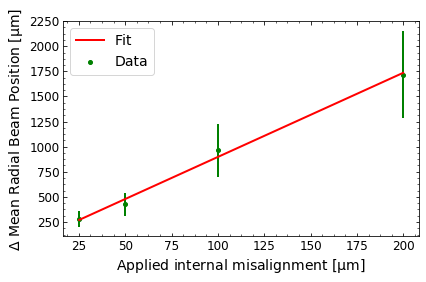

In [85]:
plotLineFit(r"$\Delta$ Mean Radial Beam Position [$\mathrm{\mu}$m]", "Applied internal misalignment [$\mathrm{\mu}$m]", points, errors)

In [3]:
# cm -> um
points.y=points.y*1e4
errors.y=errors.y*1e4
error=0.02727 * 1e4 # cm -> um
# error=0.89045 # um 

In [4]:
# ?plt.legend

In [7]:
def plotAlign(y_title, pred, sim, sim_errors):
    f=plt.figure()
    ax = f.add_subplot(111)
    ax.scatter(pred.x, pred.y, color="blue", s=12, label="Analytically predicted")
    ax.errorbar(pred.x, sim.y, yerr=sim_errors, color="green", elinewidth=1, linewidth=0, label="Reconstructed from simulation")
    ax.set_xlabel("Module and layer seperation [cm]", fontsize=font_size)
    ax.legend(loc="best", fontsize=font_size)
    ax.tick_params(axis="both", which="both", direction="in")
    ax.yaxis.set_ticks_position('both')
    ax.xaxis.set_ticks_position('both')
    plt.minorticks_on()
    plt.xticks(fontsize=font_size-2)
    plt.yticks(fontsize=font_size-2)
    plt.ylim(plt.ylim()[0]+plt.ylim()[0]*0.4, plt.ylim()[1])
    ax.set_ylabel(y_title, fontsize=font_size)
    f.tight_layout()
    f.savefig(y_title.split(" ",1)[0]+".png", dpi=300)
    

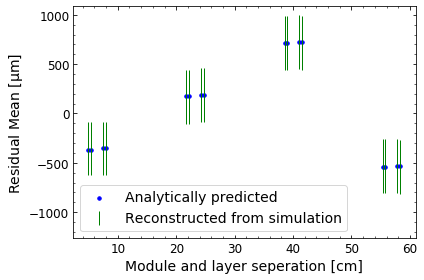

In [8]:
# for a constant errors
mean_error=np.ones(totalN)*error
plotAlign("Residual Mean [$\mathrm{\mu}$m]", points, errors, mean_error)

In [8]:
# ?plt.tick_params

In [9]:
import sys, math, os
sys.path.append(os.environ["JUPYROOT"])
import ROOT as r

Welcome to JupyROOT 6.18/04


In [10]:
from ROOT import TFile, TStyle, TCanvas, gStyle, TF1, gROOT, TMath, TLegend
r.gROOT.Macro("~/rootlogon.C")
gStyle.SetOptStat(0) # we only want the event number in range (i.e. integral)
gStyle.SetOptFit(0) # use legend to put fit details 
c = TCanvas("c", "", 1000, 750) 


 ~/rootlogon.C loaded with !!4 sig.fig.!! for custom Opt Fit and Stat!


In [11]:
file= "/Users/gleb/software/alignTrack/mpIIDESY/Plots/Tracker.root"
path =  "All_Hits/h_chi2_recon"
t_file = TFile.Open(file) 
h_plot = t_file.Get(path)
h_plot.Rebin(2)

<ROOT.TH1F object ("h_chi2_recon") at 0x7fdd311b3ba0>

100000


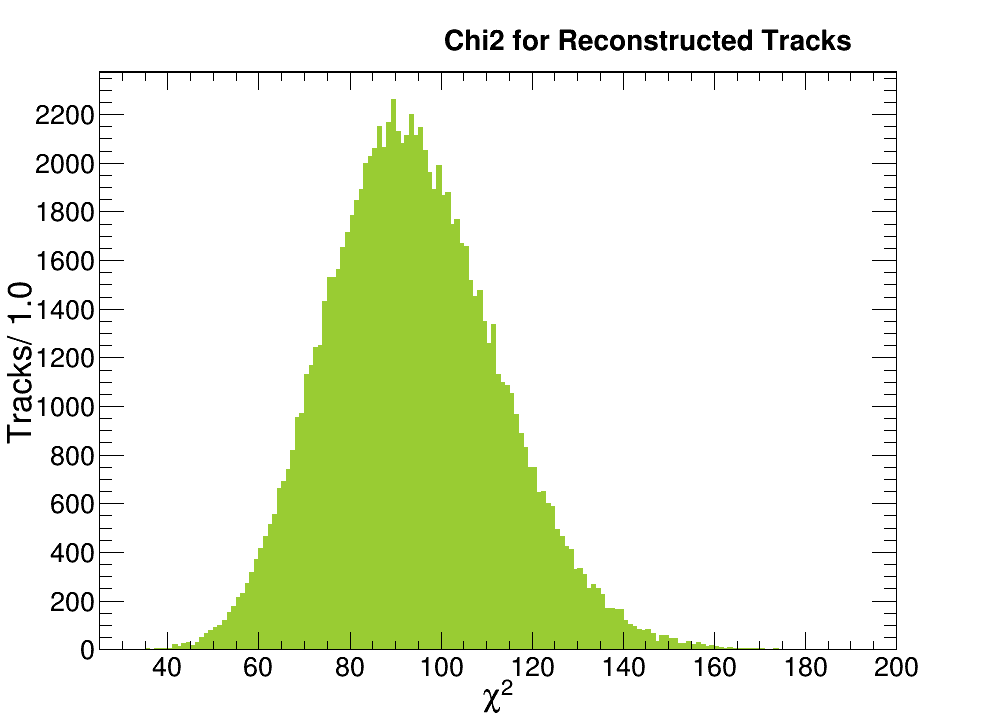

In [12]:
h_plot.Draw()
Xaxis = h_plot.GetXaxis()
Yaxis = h_plot.GetYaxis()
Xaxis.SetRangeUser(25, 200)
bmin = Xaxis.FindBin(25)
bmax = Xaxis.FindBin(200)
entries = h_plot.Integral(bmin,bmax)
print(int(entries))
binW=h_plot.GetBinWidth(1) 
Xaxis.SetTitle("#chi^{2}")
h_plot.GetYaxis().SetTitle("Tracks/ %.1f" % binW)
Xaxis.CenterTitle()
Yaxis.CenterTitle()
Xaxis.SetTitleOffset(0.8)
Yaxis.SetTitleOffset(1.0)
c.Draw()

In [13]:
chi2pdf = TF1("chi2pdf","[2]*ROOT::Math::noncentral_chisquared_pdf(x,[0],[1])",40, 180);
chi2pdf.SetParameters(94.04, 14, 1000) 
# chi2pdf.FixParameter(0, 94.04)
chi2pdf.SetLineColor(2)
chi2pdf.SetLineStyle(2)
h_plot.Fit('chi2pdf','SREM') # fit in range (R), TMinut fit (M), Minos errors (E)

 FCN=161.994 FROM MINOS     STATUS=SUCCESSFUL     20 CALLS         169 TOTAL
                     EDM=1.19637e-11    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0           1.40398e+01   7.58011e-01   1.57918e-05   6.16493e-06
   2  p1           7.99159e+01   7.63812e-01  -1.67937e-05   6.61765e-06
   3  p2           9.98396e+04   3.16028e+02   3.16028e+02  -1.78847e-10


1.199957566231615
161.99427144126804 135


Info in <TCanvas::Print>: png file chi2.png has been created


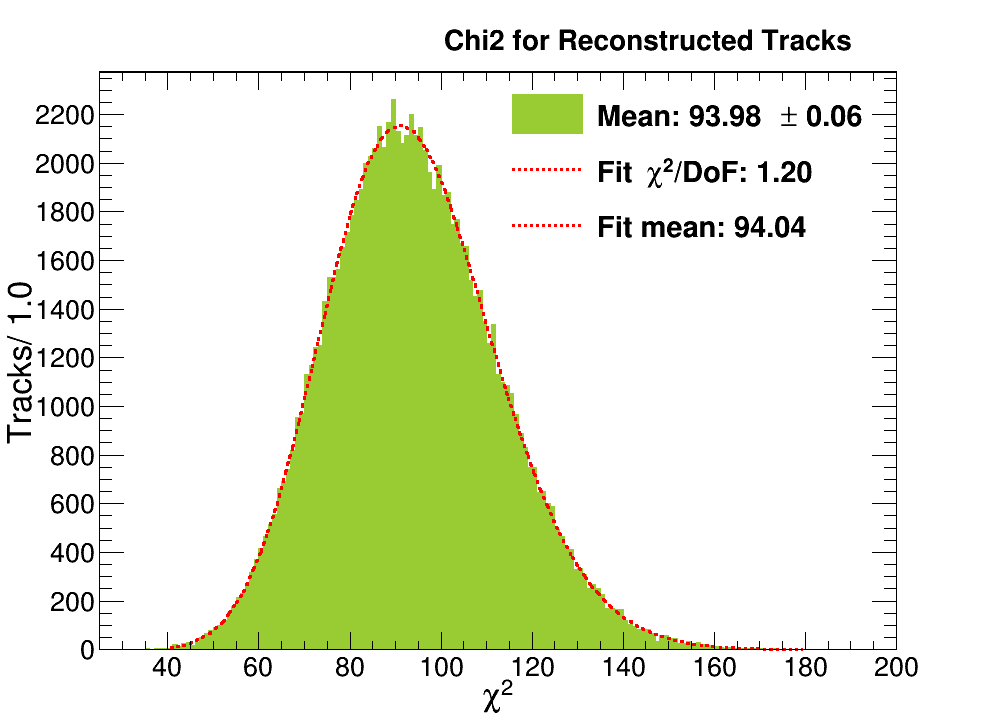

In [26]:
# Get the fit parameters
chi2=chi2pdf.GetChisquare()
ndf=chi2pdf.GetNDF()
ch2ndf=chi2/ndf
print(ch2ndf)
print(chi2, ndf)

legend =  TLegend(0.50,0.65,0.90,0.88)
# legend.SetHeader(r"#chi^{2} fit", "C")
# legenValue1 = "Entries: %.d" % entries
legenValue2 = "Fit #chi^{2}/DoF: %.2f" % ch2ndf
legenValue3 = "Mean: %.2f #pm %.2f" % (h_plot.GetMean(), h_plot.GetMeanError())
legenValue4 = "Fit mean: 94.04"
# legend.AddEntry(h_plot, legenValue1, "f")
legend.AddEntry(h_plot, legenValue3, "f")
legend.AddEntry(chi2pdf, legenValue2, "l")
legend.AddEntry(chi2pdf, legenValue4, "l")
gStyle.SetLegendBorderSize(0)
gStyle.SetLegendTextSize(0.044)
legend.SetFillStyle(0)
legend.Draw()

c.Draw()
c.SaveAs("chi2.png")